# NASDAQ-100 Data Preprocessing (CS 171 Final Project)

This is the preprocessing notebook for my part of the CS 171 final project.  
I’m working with the **NASDAQ-100 index**, while my teammate is working on the S&P 500.

In this notebook, I basically do the following:

- Get the NASDAQ-100 data using `yfinance`
- Clean the dataset
- Create useful features (returns, moving averages, volatility, RSI, etc.)
- Build the label for whether the index goes **up** the next day
- Make the train/validation/test splits based on time
- Save everything so I can use it in my modeling notebook later

This notebook focuses purely on **data collection and pre-processing**. I will build and train the machine learning models in a separate **Model Construction** notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# keeping things reproducible
np.random.seed(42)

# nicer plots
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

## 1. Downloading NASDAQ-100 Data

Originally I checked Kaggle but most datasets were way too short.  
`yfinance` gives me around 20+ years of data which is perfect for this project.

Here I download `^NDX` from 2000–2024.

In [3]:
start_dt = "2000-01-01"
end_dt = "2024-12-31"
ticker = "^NDX"   # NASDAQ-100 index ticker

# download daily OHLCV data
ndx_raw = yf.download(ticker, start=start_dt, end=end_dt)

# move date out of the index into its own column
ndx_raw = ndx_raw.reset_index()

ndx_raw.head()

/var/folders/57/5_c0gzws2kzbkc1_vj90f8v40000gn/T/ipykernel_49958/1956323300.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ndx_raw = yf.download(ticker, start=start_dt, end=end_dt)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,^NDX,^NDX,^NDX,^NDX,^NDX
0,2000-01-03,3790.550049,3836.860107,3643.25000,3755.739990,1510070000
1,2000-01-04,3546.199951,3766.570068,3542.72998,3766.570068,1511840000
2,2000-01-05,3507.310059,3576.169922,3371.75000,3543.129883,1735670000
3,2000-01-06,3340.810059,3513.550049,3334.02002,3488.310059,1598320000
4,2000-01-07,3529.600098,3529.750000,3314.75000,3337.260010,1634930000


Sometimes yfinance returns MultiIndex columns (tuples).  
This ends up breaking `.lower()` when renaming columns.

So before renaming, I flatten any tuple columns into simple strings.

In [5]:
# flatten tuple columns if they exist
# (yfinance sometimes returns ('Adj Close', '^NDX') instead of 'Adj Close')
ndx_raw.columns = [col[0] if isinstance(col, tuple) else col for col in ndx_raw.columns]

# rename to snake_case so they're easier to type later
ndx_raw.columns = [col.lower().replace(" ", "_") for col in ndx_raw.columns]

ndx_raw.info()
ndx_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6288 entries, 0 to 6287
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6288 non-null   datetime64[ns]
 1   close   6288 non-null   float64       
 2   high    6288 non-null   float64       
 3   low     6288 non-null   float64       
 4   open    6288 non-null   float64       
 5   volume  6288 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 294.9 KB


,date,close,high,low,open,volume
0,2000-01-03,3790.550049,3836.860107,3643.25000,3755.739990,1510070000
1,2000-01-04,3546.199951,3766.570068,3542.72998,3766.570068,1511840000
2,2000-01-05,3507.310059,3576.169922,3371.75000,3543.129883,1735670000
3,2000-01-06,3340.810059,3513.550049,3334.02002,3488.310059,1598320000
4,2000-01-07,3529.600098,3529.750000,3314.75000,3337.260010,1634930000


## 2. Quick data check
Just making sure the data looks correct and checking for missing values.

In [6]:
print("Date range:", ndx_raw["date"].min(), "→", ndx_raw["date"].max())
ndx_raw.isna().sum()

Date range: 2000-01-03 00:00:00 → 2024-12-30 00:00:00


date      0
close     0
high      0
low       0
open      0
volume    0
dtype: int64

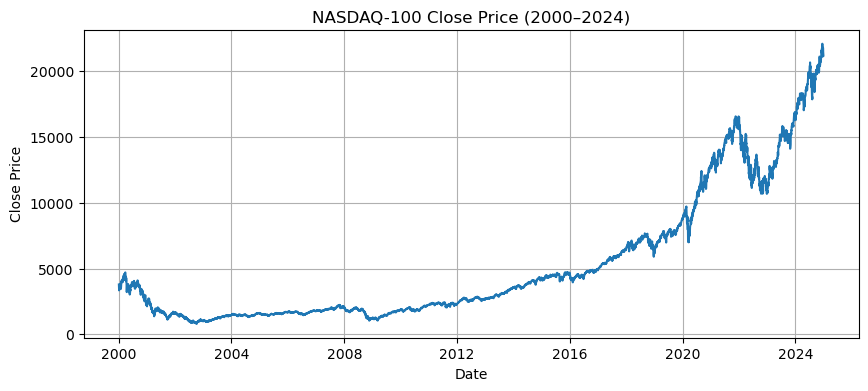

In [8]:
plt.plot(ndx_raw["date"], ndx_raw["close"])
plt.title("NASDAQ-100 Close Price (2000–2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


The long-term trend looks good and shows major events like the dot-com crash, 2008, COVID, etc.

Now I start generating features for the ML models.


## 3. Feature Engineering

Here I create financial features that ML models can learn from:

- daily returns  
- log returns  
- moving averages  
- price / moving-average ratios  
- rolling volatility  
- RSI (momentum indicator)

I mostly use the `close` price since the dataset doesn't have `adj_close`.


In [9]:
df = ndx_raw.copy()
df = df.sort_values("date").reset_index(drop=True)

# 1-day percent return
df["ret_1d"] = df["close"].pct_change()

# log return (can be more stable for modeling)
df["log_ret_1d"] = np.log(df["close"] / df["close"].shift(1))

df.head()


,date,close,high,low,open,volume,ret_1d,log_ret_1d
0,2000-01-03,3790.550049,3836.860107,3643.25000,3755.739990,1510070000,NaN,NaN
1,2000-01-04,3546.199951,3766.570068,3542.72998,3766.570068,1511840000,-0.064463,-0.066635
2,2000-01-05,3507.310059,3576.169922,3371.75000,3543.129883,1735670000,-0.010967,-0.011027
3,2000-01-06,3340.810059,3513.550049,3334.02002,3488.310059,1598320000,-0.047472,-0.048636
4,2000-01-07,3529.600098,3529.750000,3314.75000,3337.260010,1634930000,0.056510,0.054971


In [10]:
ma_windows = [5, 10, 20]

for w in ma_windows:
    # simple moving average
    df[f"ma_{w}"] = df["close"].rolling(w).mean()
    
    # price relative to the moving average (trend strength)
    df[f"price_over_ma_{w}"] = df["close"] / df[f"ma_{w}"]

df.head(10)


,date,close,high,low,open,volume,ret_1d,log_ret_1d,ma_5,price_over_ma_5,ma_10,price_over_ma_10,ma_20,price_over_ma_20
0,2000-01-03,3790.550049,3836.860107,3643.250000,3755.739990,1510070000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,3546.199951,3766.570068,3542.729980,3766.570068,1511840000,-0.064463,-0.066635,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,3507.310059,3576.169922,3371.750000,3543.129883,1735670000,-0.010967,-0.011027,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,3340.810059,3513.550049,3334.020020,3488.310059,1598320000,-0.047472,-0.048636,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,3529.600098,3529.750000,3314.750000,3337.260010,1634930000,0.056510,0.054971,3542.894043,0.996248,NaN,NaN,NaN,NaN
5,2000-01-10,3717.409912,3756.169922,3558.209961,3558.209961,1691710000,0.053210,0.051843,3528.266016,1.053608,NaN,NaN,NaN,NaN
6,2000-01-11,3544.350098,3717.169922,3517.790039,3715.219971,1694460000,-0.046554,-0.047672,3527.896045,1.004664,NaN,NaN,NaN,NaN
7,2000-01-12,3478.139893,3572.620117,3447.899902,3548.770020,1525900000,-0.018680,-0.018857,3522.062012,0.987529,NaN,NaN,NaN,NaN
8,2000-01-13,3612.080078,3612.429932,3494.389893,3495.830078,1476970000,0.038509,0.037786,3576.316016,1.010000,NaN,NaN,NaN,NaN
9,2000-01-14,3704.739990,3744.889893,3653.300049,3653.300049,1656630000,0.025653,0.025329,3611.343994,1.025862,3577.119019,1.035677,NaN,NaN


In [11]:
# rolling 10-day / 20-day volatility using log returns
df["vol_10d"] = df["log_ret_1d"].rolling(10).std()
df["vol_20d"] = df["log_ret_1d"].rolling(20).std()

df.head()


,date,close,high,low,open,volume,ret_1d,log_ret_1d,ma_5,price_over_ma_5,ma_10,price_over_ma_10,ma_20,price_over_ma_20,vol_10d,vol_20d
0,2000-01-03,3790.550049,3836.860107,3643.25000,3755.739990,1510070000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,3546.199951,3766.570068,3542.72998,3766.570068,1511840000,-0.064463,-0.066635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,3507.310059,3576.169922,3371.75000,3543.129883,1735670000,-0.010967,-0.011027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,3340.810059,3513.550049,3334.02002,3488.310059,1598320000,-0.047472,-0.048636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,3529.600098,3529.750000,3314.75000,3337.260010,1634930000,0.056510,0.054971,3542.894043,0.996248,NaN,NaN,NaN,NaN,NaN,NaN


### RSI (Relative Strength Index)

We didn’t calculate RSI in CS 171, but it’s common in finance so I decided to include it.

I wrote a simple helper function for it.


In [13]:
def calc_rsi(series, window=14):
    """
    Basic RSI formula.
    Not optimized — just a simple implementation for this project.
    """
    diff = series.diff()

    gains = np.where(diff > 0, diff, 0)
    losses = np.where(diff < 0, -diff, 0)

    gains = pd.Series(gains, index=series.index)
    losses = pd.Series(losses, index=series.index)

    avg_gain = gains.rolling(window).mean()
    avg_loss = losses.rolling(window).mean()

    rs = avg_gain / (avg_loss + 1e-9)   # avoid division by zero
    rsi = 100 - (100 / (1 + rs))
    return rsi

df["rsi_14"] = calc_rsi(df["close"], 14)

df.head(20)


,date,close,high,low,open,volume,ret_1d,log_ret_1d,ma_5,price_over_ma_5,ma_10,price_over_ma_10,ma_20,price_over_ma_20,vol_10d,vol_20d,rsi_14
0,2000-01-03,3790.550049,3836.860107,3643.250000,3755.739990,1510070000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,3546.199951,3766.570068,3542.729980,3766.570068,1511840000,-0.064463,-0.066635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,3507.310059,3576.169922,3371.750000,3543.129883,1735670000,-0.010967,-0.011027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,3340.810059,3513.550049,3334.020020,3488.310059,1598320000,-0.047472,-0.048636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,3529.600098,3529.750000,3314.750000,3337.260010,1634930000,0.056510,0.054971,3542.894043,0.996248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2000-01-10,3717.409912,3756.169922,3558.209961,3558.209961,1691710000,0.053210,0.051843,3528.266016,1.053608,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2000-01-11,3544.350098,3717.169922,3517.790039,3715.219971,1694460000,-0.046554,-0.047672,3527.896045,1.004664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2000-01-12,3478.139893,3572.620117,3447.899902,3548.770020,1525900000,-0.018680,-0.018857,3522.062012,0.987529,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2000-01-13,3612.080078,3612.429932,3494.389893,3495.830078,1476970000,0.038509,0.037786,3576.316016,1.010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2000-01-14,3704.739990,3744.889893,3653.300049,3653.300049,1656630000,0.025653,0.025329,3611.343994,1.025862,3577.119019,1.035677,NaN,NaN,NaN,NaN,NaN


### Dropping NaN rows

Rolling window calculations create NaNs at the start, so I drop those rows here.


In [14]:
before = len(df)
df = df.dropna().reset_index(drop=True)
after = len(df)

print("Rows before:", before)
print("Rows after :", after)


Rows before: 6288
Rows after : 6268


## 4. Creating the Target Label (Next-Day Direction)

Goal: predict whether the NASDAQ-100 will **close higher tomorrow**.

So I create:

- `next_close` = tomorrow’s close  
- `target_up` = 1 if tomorrow > today, else 0  

This gives me a clean binary classification label.


In [15]:
df["next_close"] = df["close"].shift(-1)
df["target_up"] = (df["next_close"] > df["close"]).astype(int)

# drop last row because next_close is NaN there
df = df.iloc[:-1].reset_index(drop=True)

df[["date", "close", "next_close", "target_up"]].head()


,date,close,next_close,target_up
0,2000-02-01,3701.780029,3724.459961,1
1,2000-02-02,3724.459961,3851.159912,1
2,2000-02-03,3851.159912,3874.370117,1
3,2000-02-04,3874.370117,3933.340088,1
4,2000-02-07,3933.340088,4062.770020,1


## 5. Selecting Features + Saving the Processed Data

Here I choose the feature columns I’ll use for modeling.

I’m not scaling anything yet — I’ll apply scaling inside the modeling notebook so it's part of the training workflow.

Then I save everything into a `data/` folder.


In [16]:
feat_cols = [
    "close",
    "ret_1d", "log_ret_1d",
    "ma_5", "ma_10", "ma_20",
    "price_over_ma_5", "price_over_ma_10", "price_over_ma_20",
    "vol_10d", "vol_20d",
    "rsi_14"
]

final_df = df[["date"] + feat_cols + ["target_up"]].copy()

import os
os.makedirs("data", exist_ok=True)

final_df.to_csv("data/nasdaq100_features.csv", index=False)

final_df.head()


,date,close,ret_1d,log_ret_1d,ma_5,ma_10,ma_20,price_over_ma_5,price_over_ma_10,price_over_ma_20,vol_10d,vol_20d,rsi_14,target_up
0,2000-02-01,3701.780029,0.036899,0.036234,3586.463965,3683.497974,3628.669995,1.032153,1.004963,1.020148,0.032031,0.037532,56.083963,1
1,2000-02-02,3724.459961,0.006127,0.006108,3607.113965,3676.854980,3637.582996,1.032532,1.012947,1.023883,0.031947,0.034236,59.850592,1
2,2000-02-03,3851.159912,0.034018,0.033453,3658.715967,3677.796973,3654.775488,1.052599,1.047138,1.053734,0.033595,0.034755,59.616737,1
3,2000-02-04,3874.370117,0.006027,0.006009,3744.364014,3680.237988,3681.453491,1.034720,1.052750,1.052402,0.033642,0.032412,57.226972,1
4,2000-02-07,3933.340088,0.015221,0.015106,3817.022021,3707.476001,3701.640491,1.030474,1.060921,1.062594,0.028615,0.030503,57.442010,1


## 6. Time-Based Train / Val / Test Split

Because this is time-series data, I can't shuffle it.  
I use:

- **Train:** up to end of 2015  
- **Validation:** 2016–2019  
- **Test:** 2020+  

Tests on future data only → more realistic for finance.


In [17]:
final_df["date"] = pd.to_datetime(final_df["date"])

train_cut = pd.Timestamp("2015-12-31")
val_cut = pd.Timestamp("2019-12-31")

train_df = final_df[final_df["date"] <= train_cut]
val_df = final_df[(final_df["date"] > train_cut) & (final_df["date"] <= val_cut)]
test_df = final_df[final_df["date"] > val_cut]

len(train_df), len(val_df), len(test_df)


(4005, 1006, 1256)

In [18]:
print("Train:", train_df["date"].min(), "→", train_df["date"].max(), "| rows:", len(train_df))
print("Val:  ", val_df["date"].min(),   "→", val_df["date"].max(),   "| rows:", len(val_df))
print("Test: ", test_df["date"].min(),  "→", test_df["date"].max(),  "| rows:", len(test_df))


Train: 2000-02-01 00:00:00 → 2015-12-31 00:00:00 | rows: 4005
Val:   2016-01-04 00:00:00 → 2019-12-31 00:00:00 | rows: 1006
Test:  2020-01-02 00:00:00 → 2024-12-27 00:00:00 | rows: 1256


### Saving the splits  
This just makes the modeling notebook cleaner and easier to write.


In [19]:
train_df.to_csv("data/nasdaq100_train.csv", index=False)
val_df.to_csv("data/nasdaq100_val.csv", index=False)
test_df.to_csv("data/nasdaq100_test.csv", index=False)

print("Saved train/val/test CSVs into data/")


Saved train/val/test CSVs into data/


# Wrap-Up

In this notebook I:

- downloaded NASDAQ-100 data using yfinance
- cleaned & renamed columns (including fixing tuple-column issue)
- created financial features (returns, moving averages, volatility, RSI)
- made a binary target label for next-day movement
- removed NaNs and handled the final row correctly
- created time-based train/val/test splits
- saved everything into a `data/` folder

Next step → building the ML models (logistic regression, random forest, and an LSTM).
